# Stimare Q function ottimale
## 1. Quanto tempo ci mette per convergere a Q*, al variare di tau
## 2. Distanza tra Q* e Q_t 
## 3. distanza tra Q_0 e Q_0 appresa tramite i valori di tau
## 4. cercare di integrare i bound trovati
## 5. Test della policy appresa con tau sull'mdp originale
## 6. Performance durante l'apprendimento per verificare la convergenza
## 7. Approfondire cosa succede per 0 < tau < 0.1 

junix --filepath ./Test.ipynb --output_dir ./results/intermediate_curves

In [1]:
print('')

In [2]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)
import math
from utils import *

In [3]:
# Test with tau=0.9
nS = 8
nA = 2
seed = 3231
gamma = 0.9
river = River(nS, gamma, 5, 1000)
tau = 0.9
status_step = 500
xi = np.ones(river.nS)*1/river.nS
tmdp = TMDP(river, xi, tau, gamma, seed)

In [4]:
results = []

r_s_a = compute_r_s_a(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward)
Q_star = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward, 1e-4, gamma)
J_star = get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star), tmdp.reward, tmdp.gamma, tmdp.mu)
delta_q = np.linalg.norm(Q_star - Q_star, np.inf)
print(delta_q)
results.append({"type":"Bellman", "Q": Q_star, "tau":"/", "J":J_star, "policy":get_policy(Q_star), "delta_q":delta_q})
print(results)

0.0
[{'type': 'Bellman', 'Q': array([[ 68.0541,  70.0602],
       [ 63.0542,  96.0085],
       [ 86.4077, 140.2168],
       [126.1952, 206.8852],
       [186.1967, 305.7323],
       [275.159 , 451.9155],
       [406.724 , 668.0195],
       [601.2176, 987.4689]]), 'tau': '/', 'J': 365.78861003317843, 'policy': array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]]), 'delta_q': 0.0}]


In [5]:

taus = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0]
intermediate_results = {}
curr_j = []
delta_qs = []
Q = np.zeros((tmdp.nS, tmdp.nA))
# Curriculul for decreasing values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    M = 10500
    s = tmdp.reset()
    
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    Q, inner_J,_, inner_delta_qs, _, _ = Q_learning(tmdp, s, a, Q, Q_star, M=M, alpha=0.03, debug=True, status_step=status_step)
    curr_j.append(inner_J)
    delta_qs.append(inner_delta_qs)
curr_j = np.ravel(curr_j)
delta_qs = np.ravel(delta_qs)
intermediate_results['Curriculum'] = {'J': curr_j, "delta_q":delta_qs}
delta_q = np.linalg.norm(Q_star - Q, np.inf)
J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
results.append({"type":"curriculum", "Q": Q, "tau":"1 -> 0", "J":J, "policy":get_policy(Q), "delta_q":delta_q})



In [6]:
# Learning from scratch with different values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    Q = np.zeros((tmdp.nS, tmdp.nA))
    M = 200000
    
    s = tmdp.reset()
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    
    Q, inner_J, _,  inner_delta_qs, _, _ = Q_learning(tmdp, s, a, Q, Q_star, M=M, alpha=0.03, debug=True, status_step=status_step)
    
    intermediate_results['tau_'+str(tau)] = {'J': inner_J, "delta_q":inner_delta_qs}
    delta_q = np.linalg.norm(Q_star - Q, np.inf)
    J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
    
    results.append({"type":"scratch", "Q": Q, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q})

In [7]:
# Read previous results from file
try:
    res = read_results(tmdp.nS, tmdp.nA, "river_swim")
except:
    res = []
    
# Add current results to old ones
for r in results:
    res.append(r)





In [8]:
# Update overall results
write_results(tmdp.nS, tmdp.nA, "river_swim", res, 'w')
agg_res = aggregate_results(res, len(results))

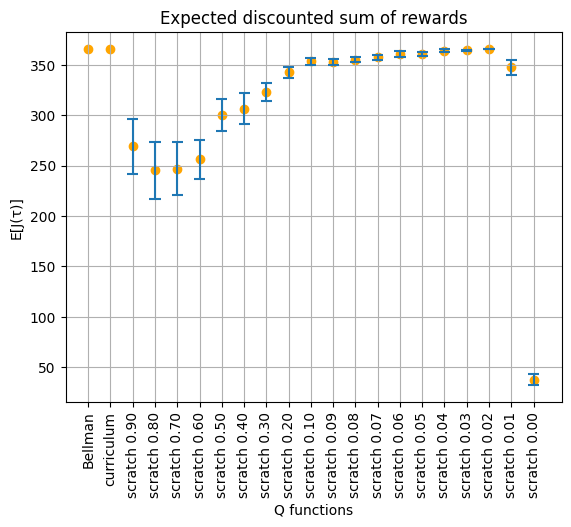

In [9]:
x = np.array([])
y = np.array([])
ci = np.array([])
for res in agg_res:
    y = np.append(y, res['avg_J'])
    label = res['type'] + " " + str(res['tau']) if res['type'] == 'scratch' else res['type']
    x = np.append(x, label)
    ci = np.append(ci, res['ci_J'])
x_map = np.array([i for i in range(len(x))])
offset = np.array([0.25 if ci[i] > 0.001 else 0 for i in range(len(x))])
#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(x, y, c='orange')
plt.xticks(x_map, x)
#plt.plot(x, y)
#plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.hlines(y=y-ci, xmin=x_map-offset, xmax=x_map + offset)
plt.hlines(y=y+ci, xmin=x_map-offset, xmax=x_map + offset)
plt.vlines(x, ymin = y-ci, ymax = y+ci)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards")
plt.grid(visible=True)




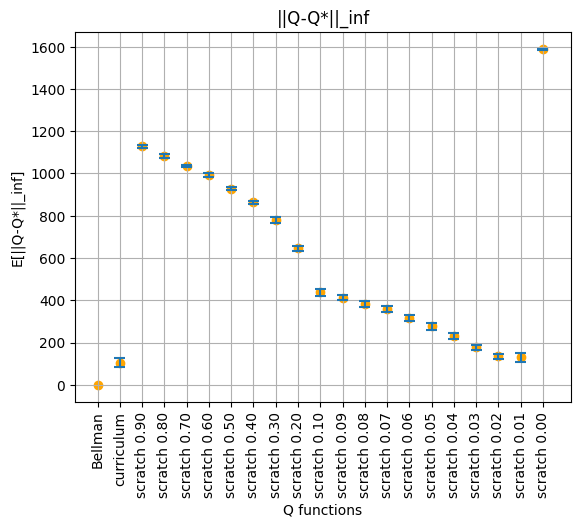

In [10]:
x = np.array([])
y = np.array([])
ci = np.array([])
for res in agg_res:
    y = np.append(y, res['avg_delta_q'])
    label = res['type'] + " " + str(res['tau']) if res['type'] == 'scratch' else res['type']
    x = np.append(x, label)
    ci = np.append(ci, res['ci_delta_q'])

offset = np.array([0.25 if ci[i] > 0.001 else 0 for i in range(len(x))])
#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(x, y, c='orange')

plt.xticks(x_map, x)
#plt.plot(x, y)
#plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.hlines(y=y-ci, xmin=x_map-offset, xmax=x_map + offset)
plt.hlines(y=y+ci, xmin=x_map-offset, xmax=x_map + offset)
plt.vlines(x, ymin = y-ci, ymax = y+ci)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel('E[||Q-Q*||_inf]')
plt.title("||Q-Q*||_inf")
plt.grid(visible=True)

In [11]:
print(len(res['J']))

19


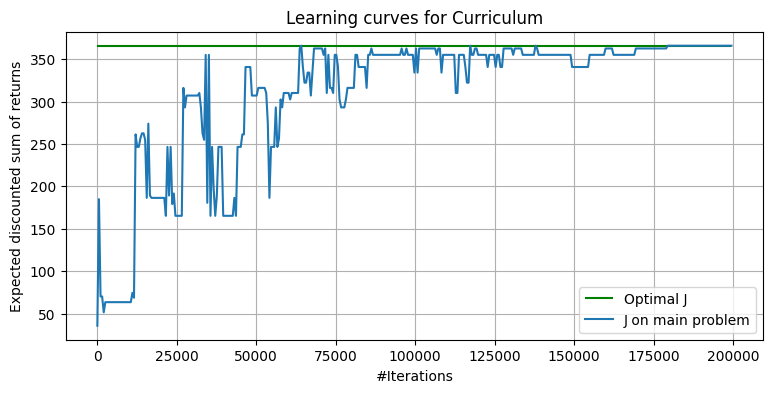

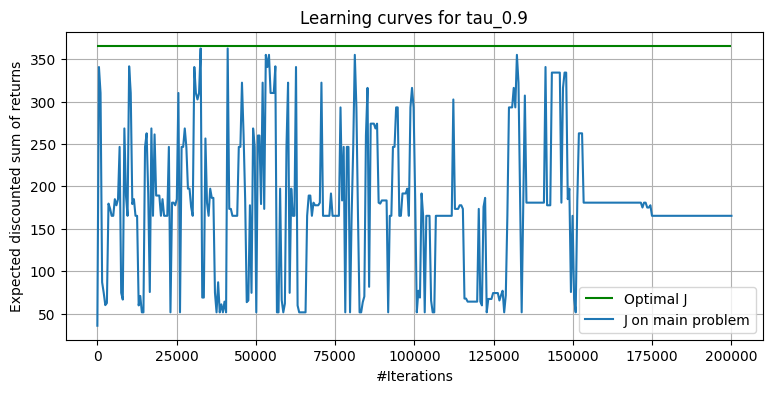

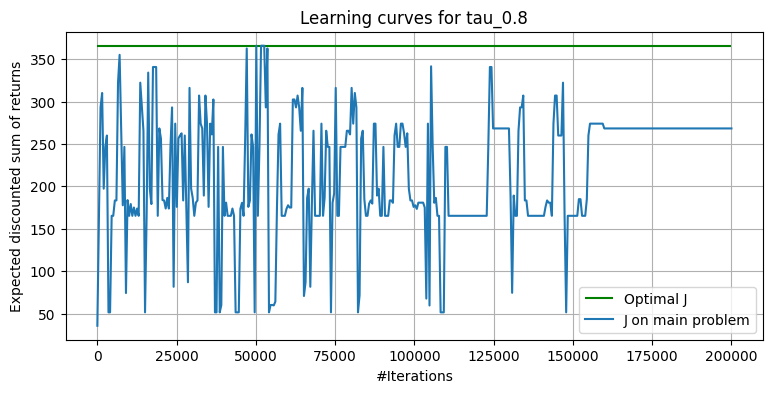

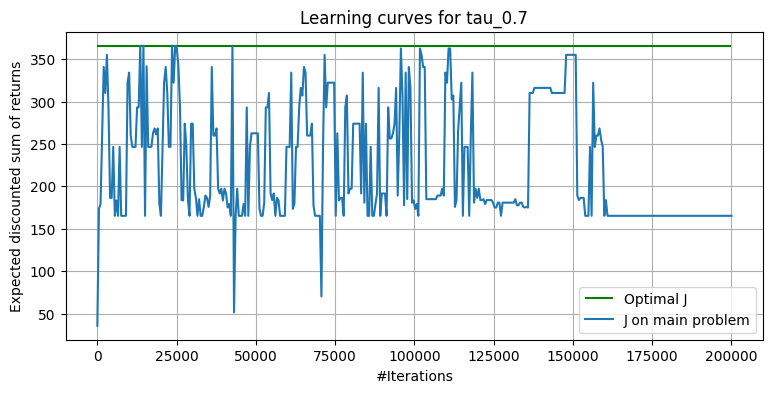

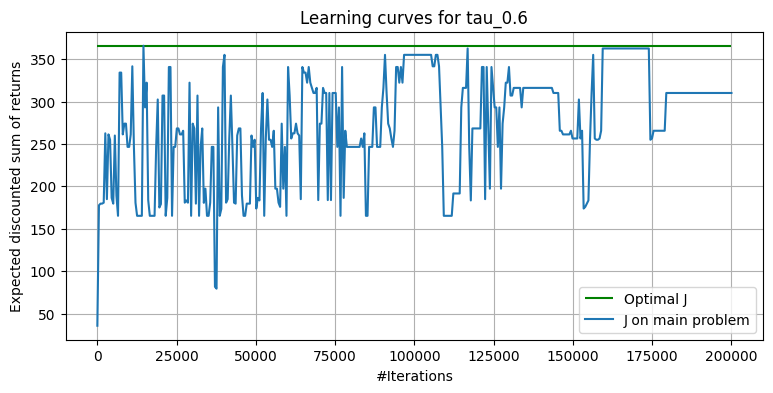

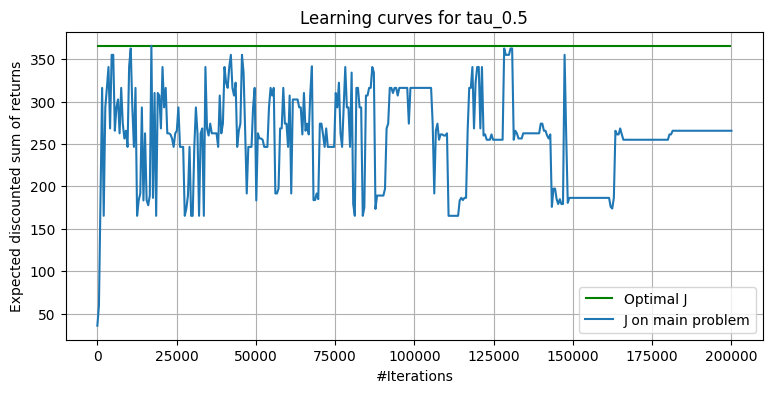

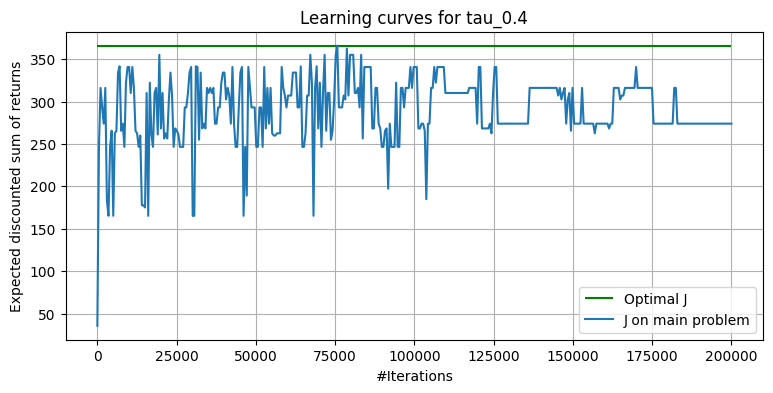

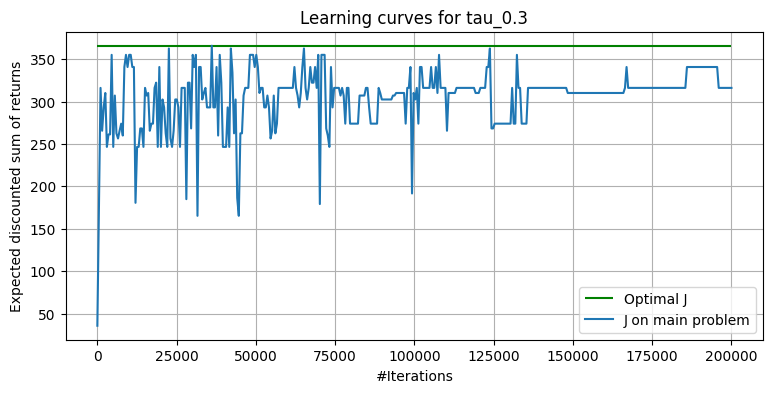

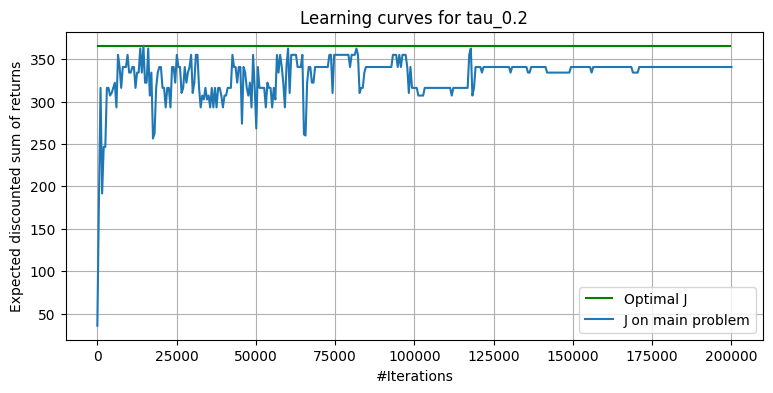

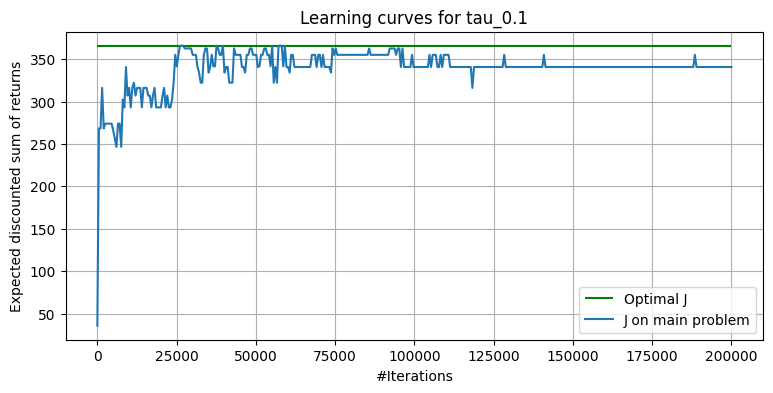

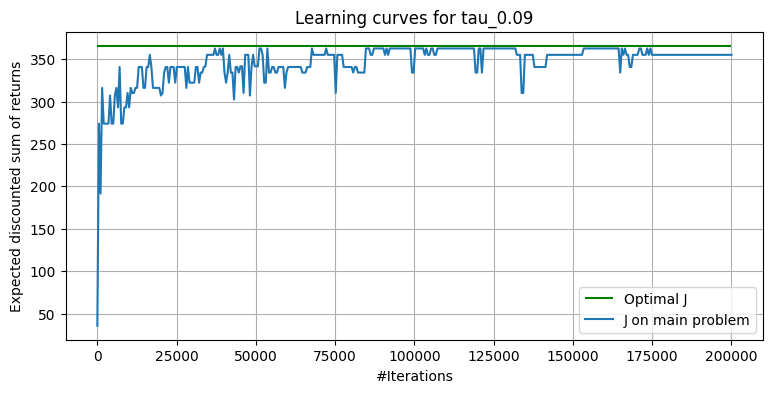

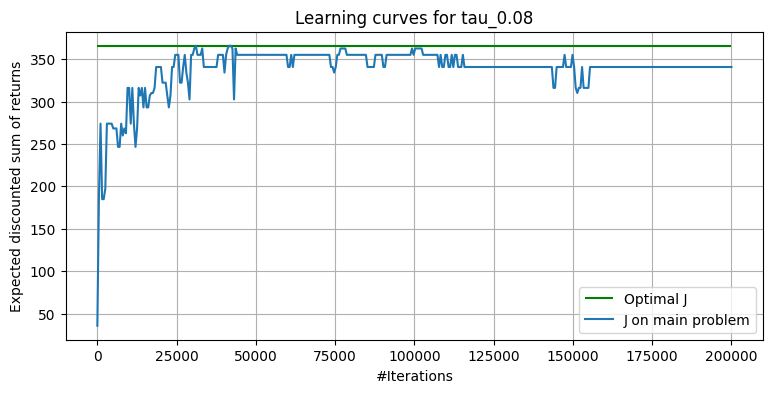

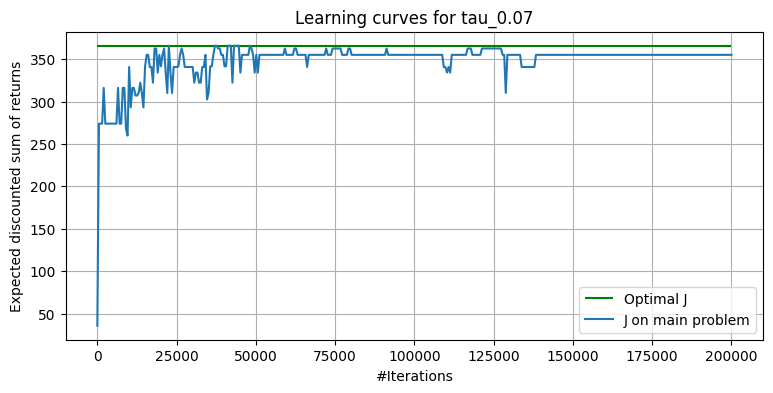

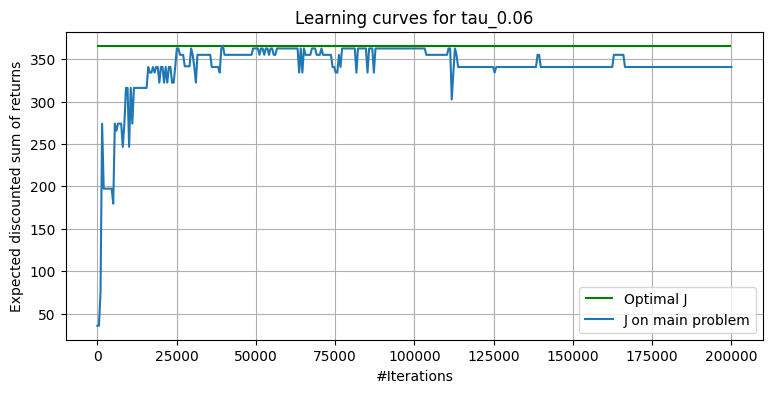

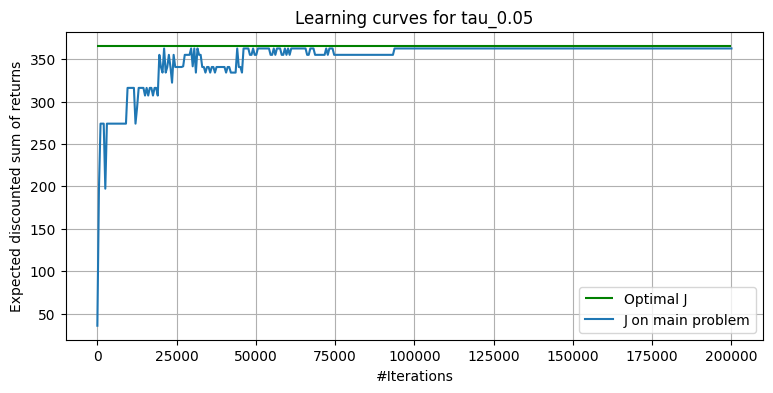

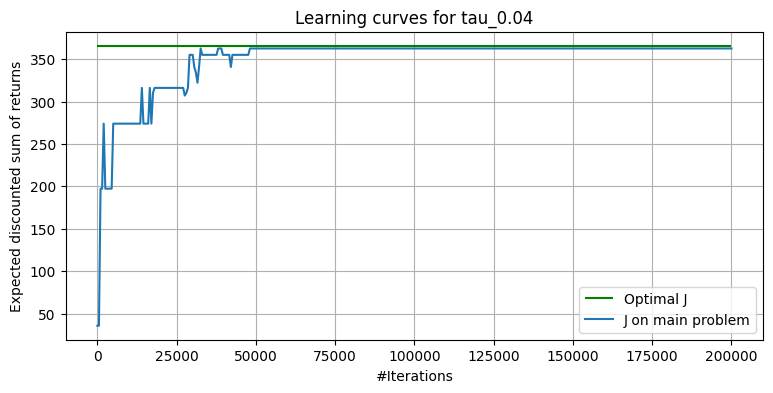

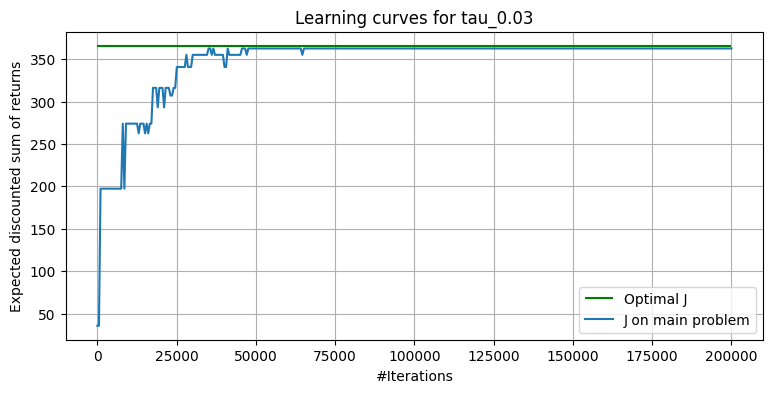

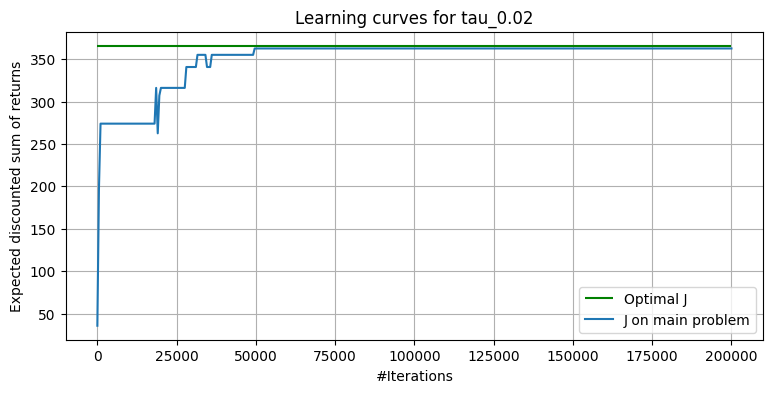

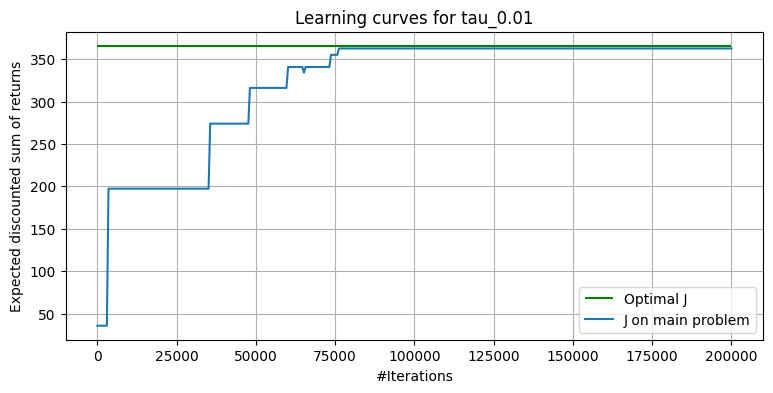

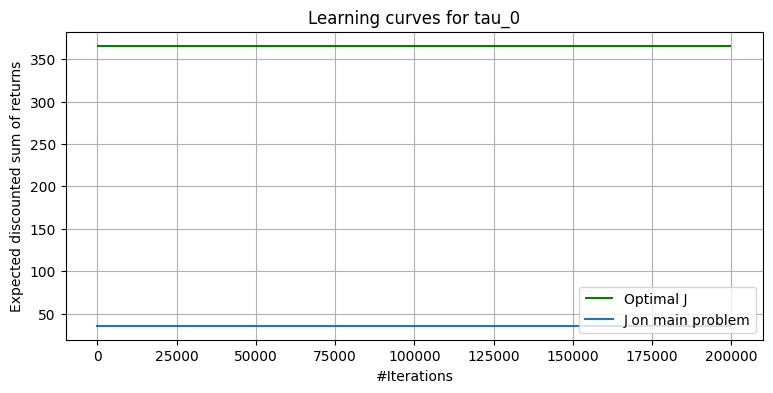

In [12]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['J'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['J']))
    y = intermediate_results[key]['J']
    plt.figure(figsize=(9, 4))
    #plt.scatter(x, y, c='orange', label='Current J')
    plt.hlines(y=J_star, xmin=0, xmax=xmax, colors=['green'], label='Optimal J')
    plt.plot(x, y, label='J on main problem')
    plt.grid(visible=True)
    plt.legend(loc="lower right")
    plt.xlabel('#Iterations')
    plt.ylabel('Expected discounted sum of returns')
    plt.title('Learning curves for '+str(key))

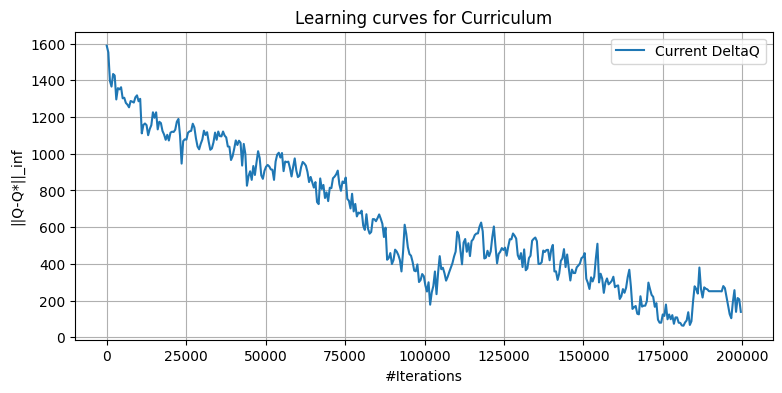

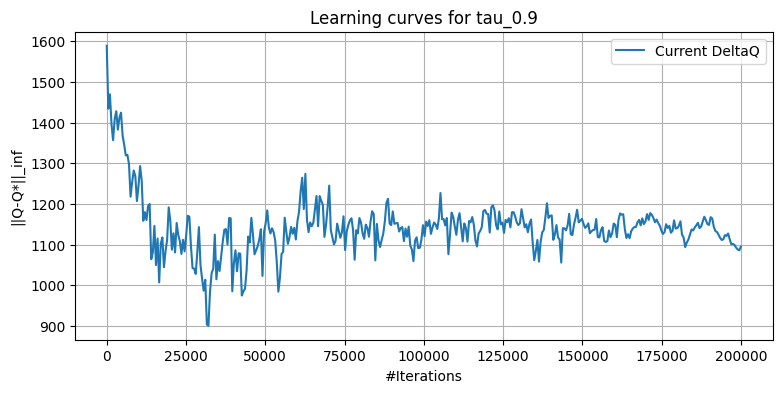

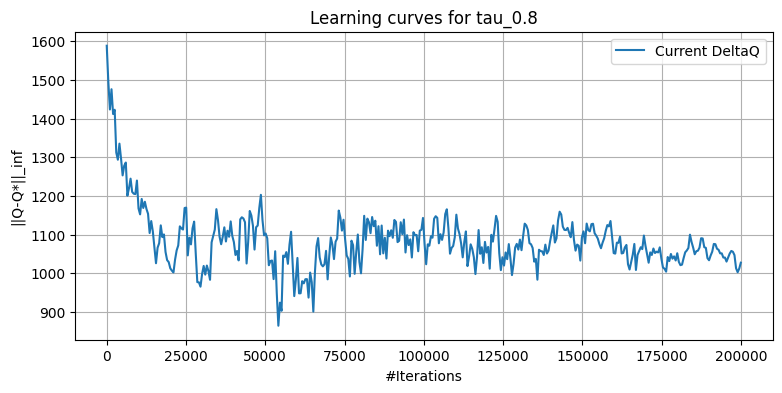

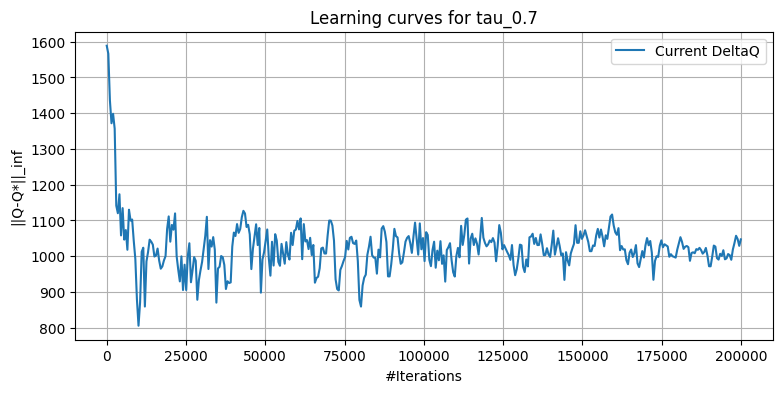

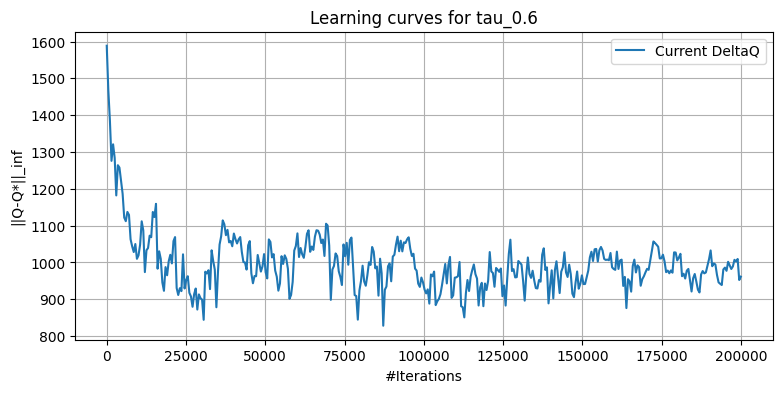

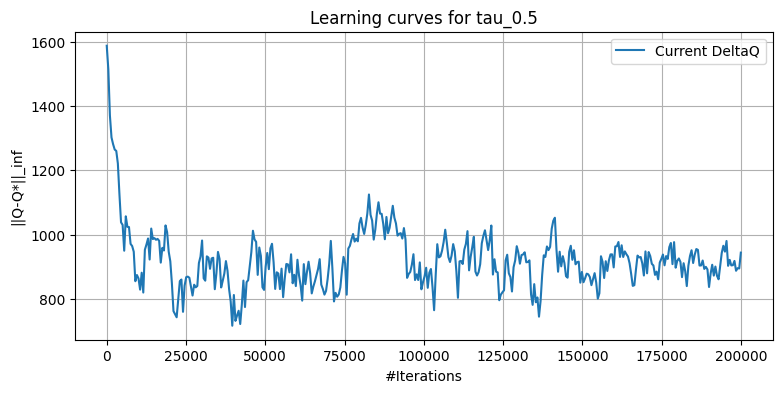

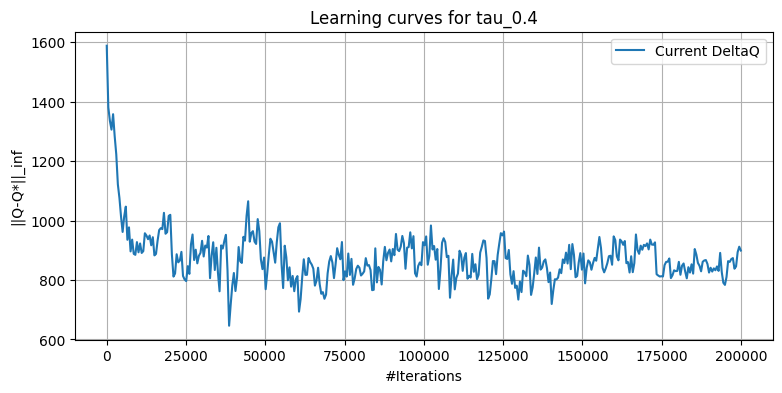

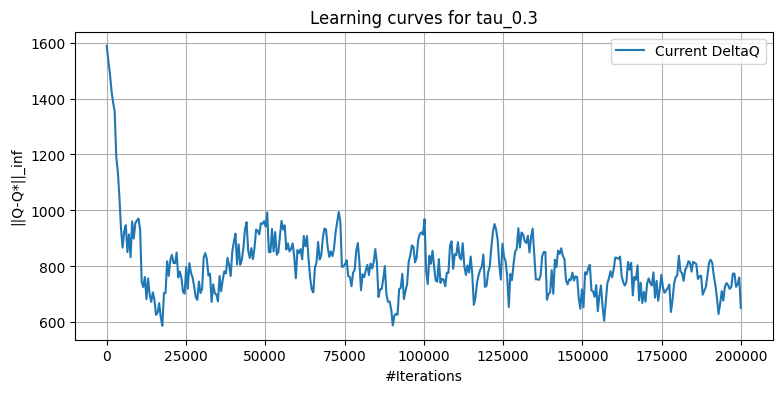

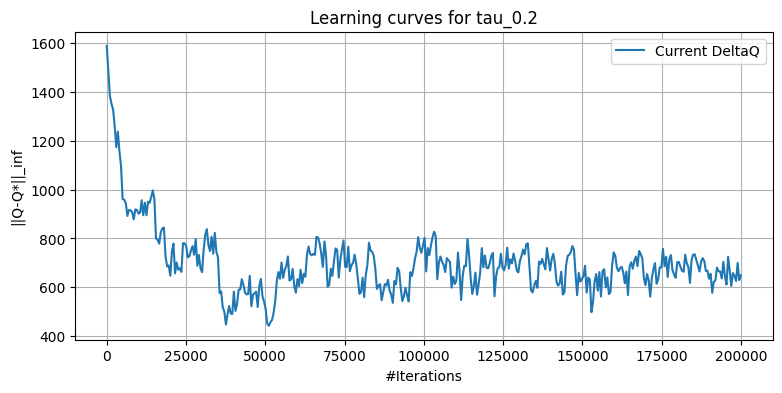

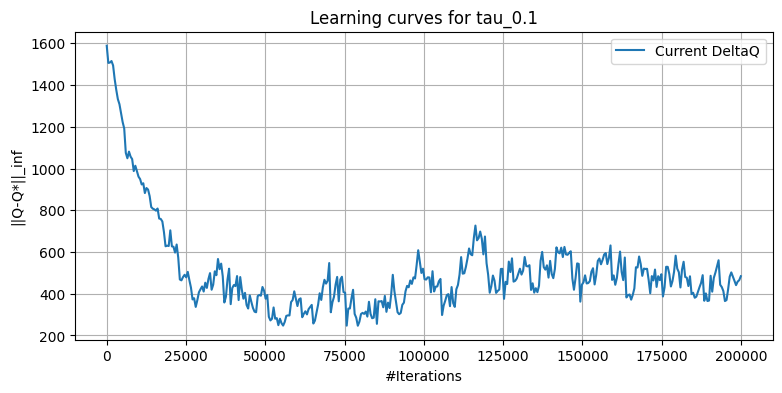

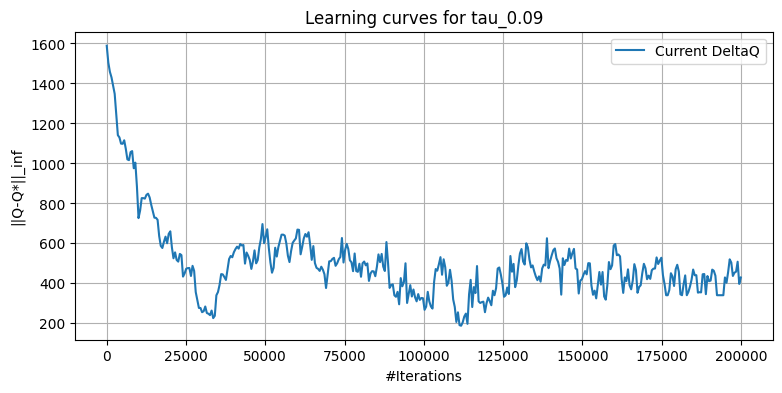

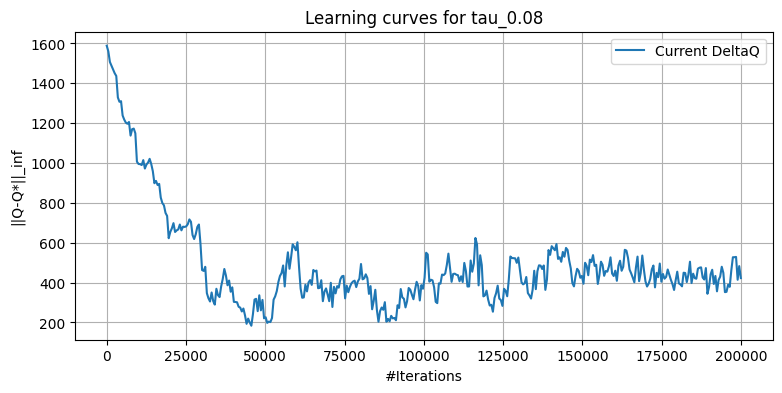

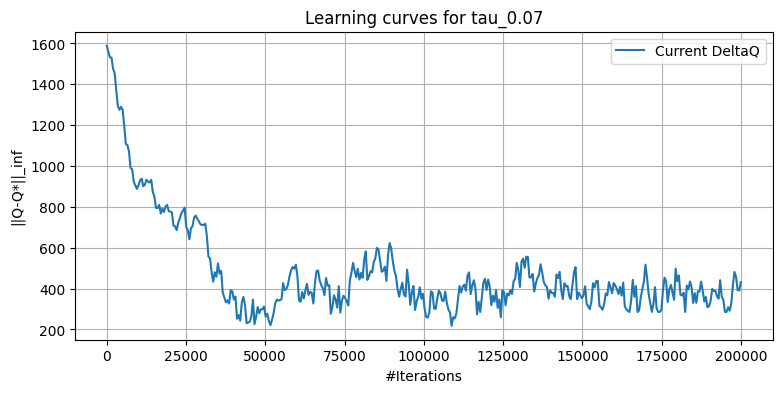

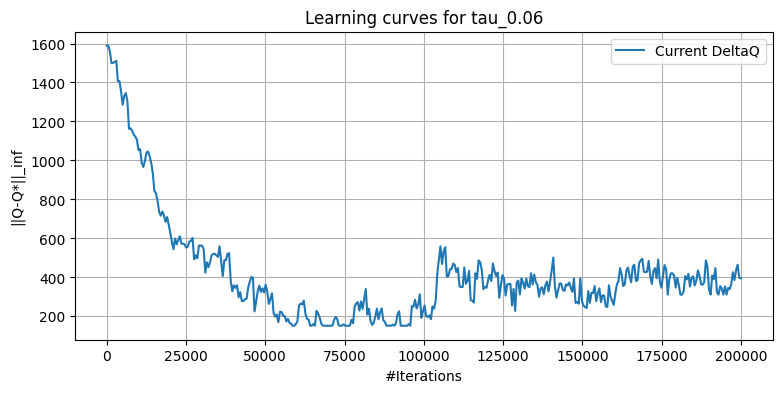

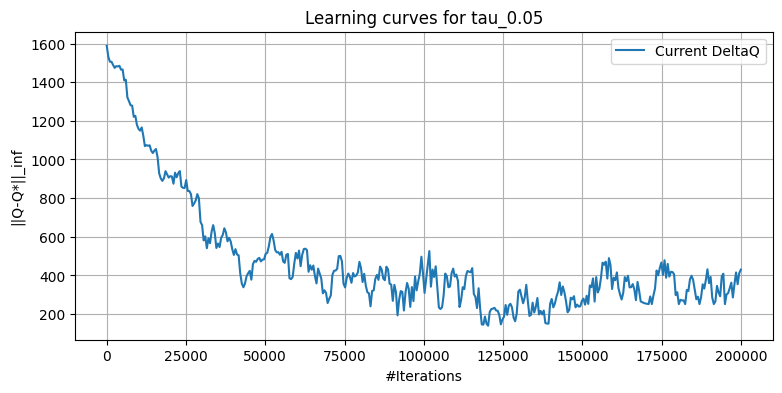

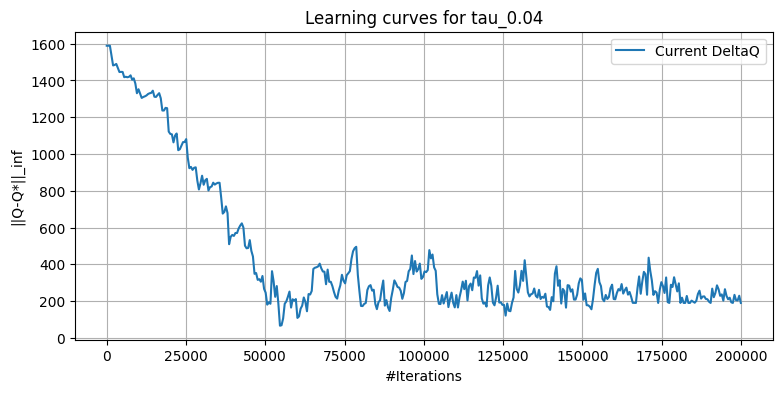

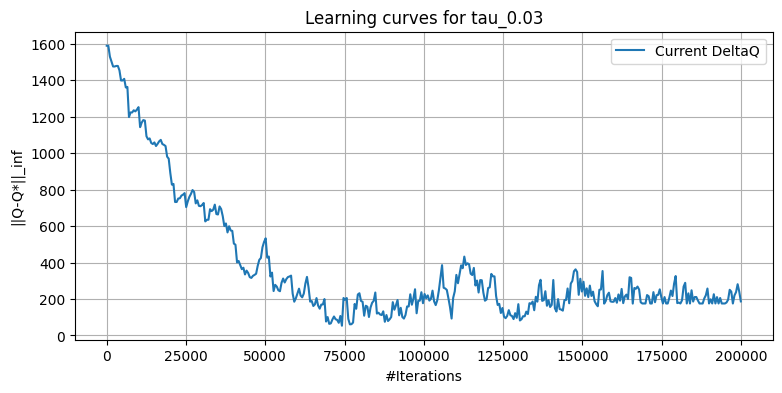

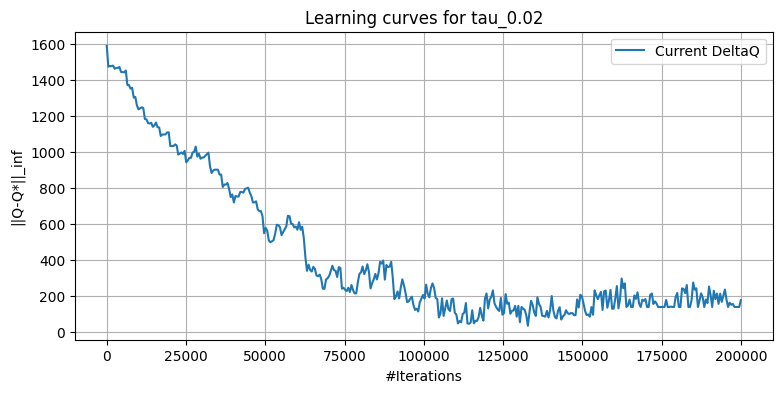

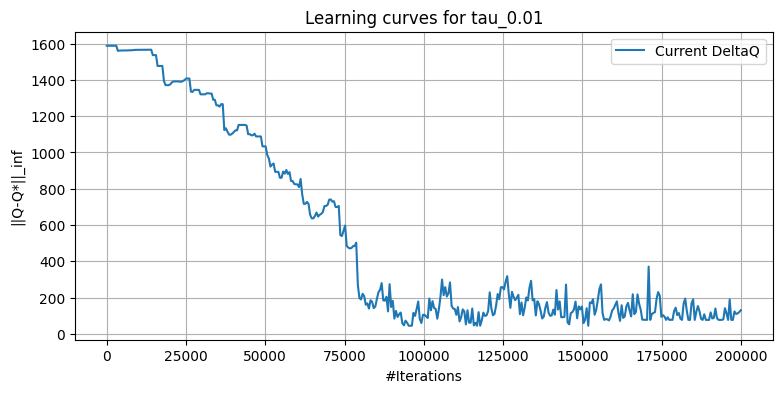

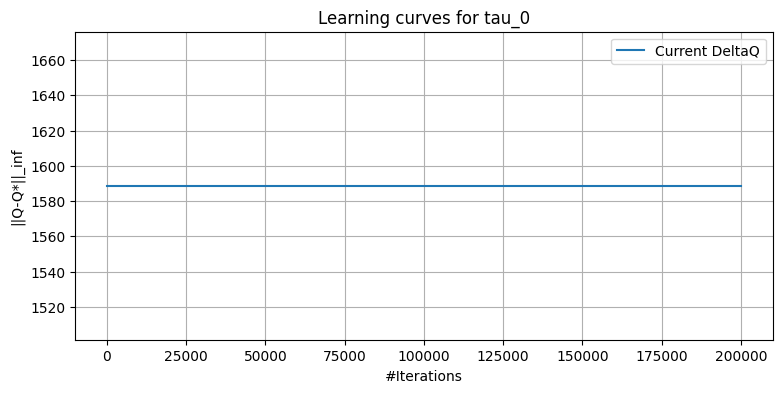

In [13]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['delta_q'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['delta_q']))
    y = intermediate_results[key]['delta_q']
    plt.figure(figsize=(9, 4))
    #plt.scatter(x, y, c='orange', label='Current DeltaQ')
    plt.plot(x, y, label='Current DeltaQ')
    plt.legend(loc="upper right")
    plt.xlabel('#Iterations')
    plt.ylabel('||Q-Q*||_inf')
    plt.grid(visible=True)
    plt.title('Learning curves for '+str(key))

In [14]:
tmdp_09 = TMDP(river, xi, 1, gamma)
tmdp_08 = TMDP(river, xi, 0, gamma)
for i in range(tmdp.P_mat_tau.shape[0]):
    x = np.linalg.norm(tmdp_09.P_mat_tau[i] - tmdp_08.P_mat_tau[i], 1)
    y = (tmdp_09.tau - tmdp_08.tau)*np.linalg.norm(tmdp_09.P_mat[i] - tmdp_08.xi, 1)
    z = 2*(tmdp_09.tau - tmdp_08.tau)
    print(x, y, z)


1.75 1.75 2
1.5 1.5 2
1.75 1.75 2
1.3 1.3 2
1.75 1.75 2
1.2999999999999998 1.2999999999999998 2
1.75 1.75 2
1.3 1.3 2
1.75 1.75 2
1.2999999999999998 1.2999999999999998 2
1.75 1.75 2
1.3 1.3 2
1.75 1.75 2
1.2999999999999998 1.2999999999999998 2
1.75 1.75 2
1.5 1.5 2


In [15]:

print(results[1]['Q'])

"""[[ 50.      43.6133]
 [ 45.      40.7878]
 [ 41.8649  42.3257]
 [ 48.5239  50.9308]
 [ 55.4385  58.5617]
 [124.949  136.0325]
 [163.5733 200.2636]
 [273.4328 409.654 ]]"""

[[ 75.7583  78.6488]
 [ 70.8497  84.7639]
 [ 80.6947 111.9917]
 [109.6911 155.9517]
 [154.5895 259.7175]
 [219.4724 402.2116]
 [338.3686 598.1527]
 [525.6096 889.9653]]


'[[ 50.      43.6133]\n [ 45.      40.7878]\n [ 41.8649  42.3257]\n [ 48.5239  50.9308]\n [ 55.4385  58.5617]\n [124.949  136.0325]\n [163.5733 200.2636]\n [273.4328 409.654 ]]'